In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 150

In [2]:
header = ['Datetime','Power']
df = pd.read_csv('channel_1.dat', sep=' ',names=header, skipinitialspace=True)
df.head()


,Datetime,Power
0,1352500095,599
1,1352500101,582
2,1352500107,600
3,1352500113,586
4,1352500120,596


In [3]:
df["Datetime"] = pd.to_datetime(df['Datetime'], unit='s')

df.head()

,Datetime,Power
0,2012-11-09 22:28:15,599
1,2012-11-09 22:28:21,582
2,2012-11-09 22:28:27,600
3,2012-11-09 22:28:33,586
4,2012-11-09 22:28:40,596


In [4]:
df.set_index("Datetime",inplace=True)
df.head()

,Power
Datetime,
2012-11-09 22:28:15,599
2012-11-09 22:28:21,582
2012-11-09 22:28:27,600
2012-11-09 22:28:33,586
2012-11-09 22:28:40,596


# Hourly Resample

In [5]:

df_H=df[['Power']].resample('D').mean()
df_H

,Power
Datetime,
2012-11-09,453.682620
2012-11-10,442.936934
2012-11-11,382.709539
2012-11-12,405.616459
2012-11-13,377.907964
...,...
2017-04-22,530.167262
2017-04-23,503.753284
2017-04-24,491.368122


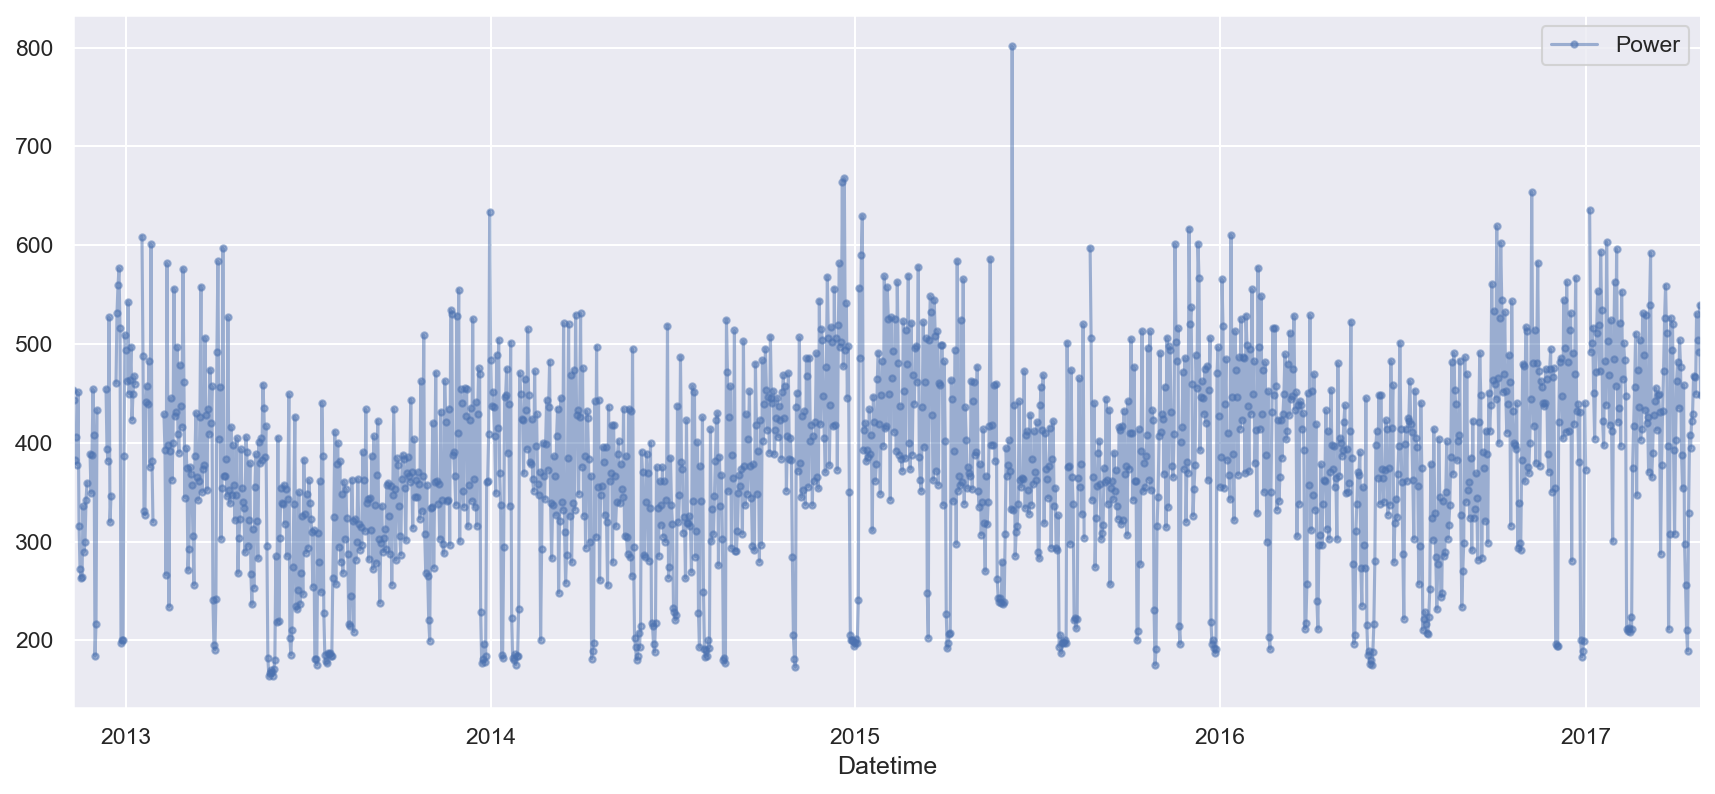

In [6]:
axes =df_H.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Checks for null values and resolves them

In [7]:
data=df_H
# Check for null values in the data
null_values = data.isnull().sum()
print(null_values)

# Drop rows with null values
data = data.dropna()

# Verify if null values have been successfully dropped
null_values_after_drop = data.isnull().sum()
print(null_values_after_drop)

Power    38
dtype: int64
Power    0
dtype: int64


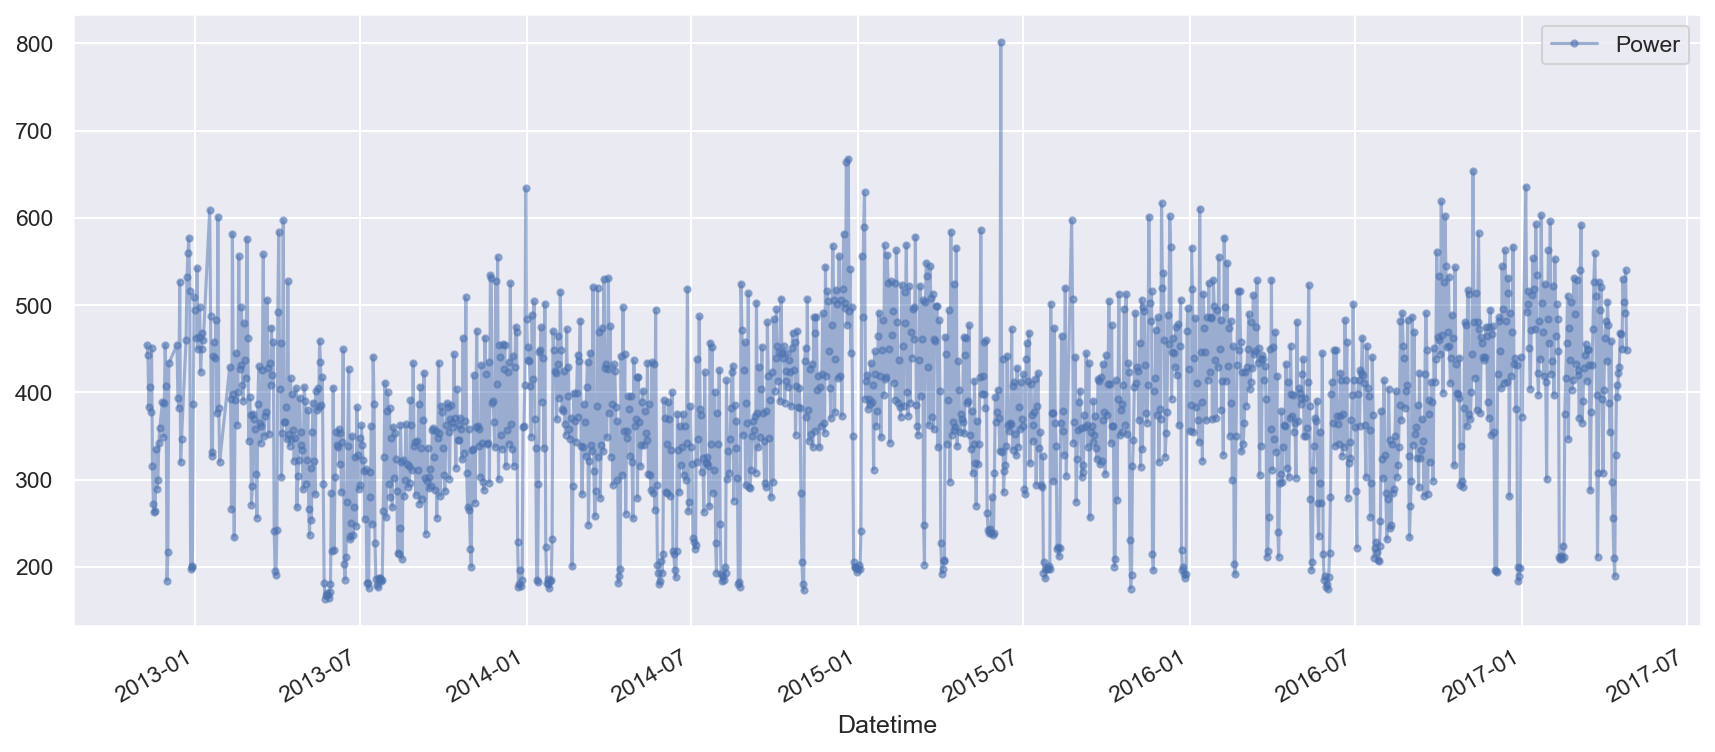

In [8]:
axes =data.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Outliers

In [9]:
from scipy import stats

# Calculate the z-scores of the data
z_scores = stats.zscore(data)

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 5

# Find the indices of the outliers
outlier_indices = (np.abs(z_scores) > threshold).any(axis=1)

In [10]:

# Remove the outliers from the data
data_without_outliers = data[~outlier_indices]

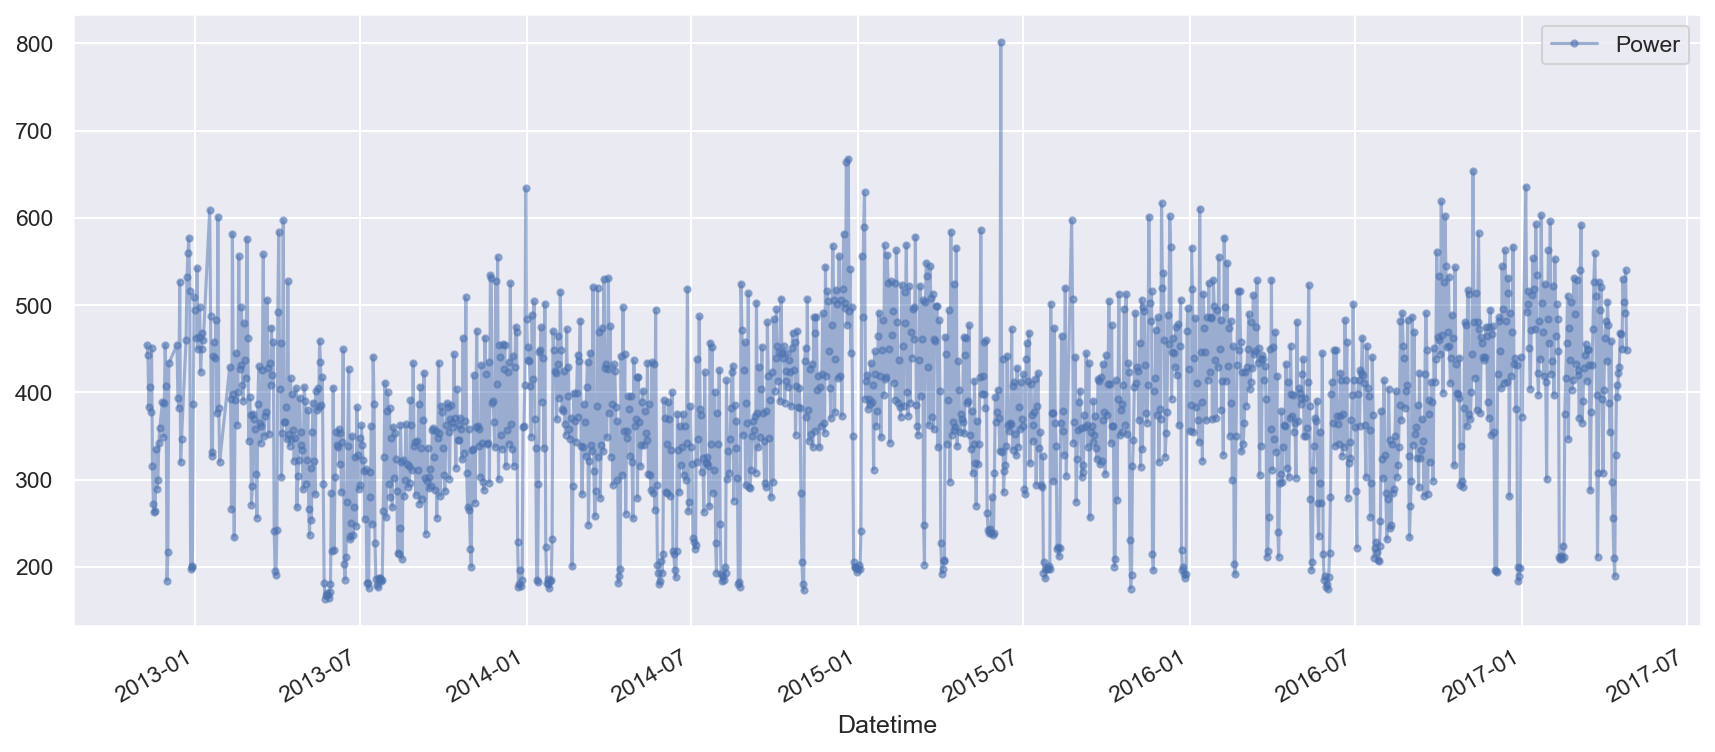

In [11]:
axes =data_without_outliers.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Testing for stationary

In [12]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
dfs = data_without_outliers

In [13]:
test_result=adfuller(dfs['Power'])

In [14]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [15]:
adfuller_test(dfs['Power'])

ADF Test Statistic : -6.460969620269115
p-value : 1.4435954589272984e-08
#Lags Used : 14
Number of Observations Used : 1577
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [16]:
## Results show that data is stationary

In [17]:
dfs


,Power
Datetime,
2012-11-09,453.682620
2012-11-10,442.936934
2012-11-11,382.709539
2012-11-12,405.616459
2012-11-13,377.907964
...,...
2017-04-22,530.167262
2017-04-23,503.753284
2017-04-24,491.368122


In [18]:
#from sklearn.preprocessing import MinMaxScaler

In [19]:
#dfs["Power"][:'2015'].plot(figsize=(16,4),legend=True)
#dfs["Power"]['2016':].plot(figsize=(16,4),legend=True)
#plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
#plt.title('Power Consumption')
#plt.show()

In [20]:
#scaler = MinMaxScaler()

# Extract the "Power" attribute
#power_data = dfs['Power'].values.reshape(-1, 1)

# Fit the scaler on the "Power" attribute data
#scaler.fit(power_data)

# Normalize the "Power" attribute
#normalized_power_data = scaler.transform(power_data)

# Update the DataFrame with the normalized values
#dfs['Power'] = normalized_power_data


#print(dfs)


In [63]:
df=dfs
def create_lags(df, days=7):
    # create lagged data for features
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['Power'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=1):
    # create 3d dataset for input
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    # yhat needs to be scaled
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['Power']
    date_idx = pd.date_range(start='2012-11-13', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

In [64]:


from sklearn.preprocessing import MinMaxScaler

chosen = dfs.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

# Fit scaler on training data only to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply scaling to each feature separately
scaled_data = chosen.copy()
for column in chosen.columns:
    scaled_data[column] = scaler.fit_transform(chosen[column].values.reshape(-1, 1))

print(scaled_data.shape)
scaled_data.head()


(1585, 8)


,Power,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
Datetime,,,,,,,,
2012-11-16,0.169698,0.238385,0.451128,0.336213,0.379670,0.343744,0.438201,0.455053
2012-11-17,0.156514,0.169698,0.238385,0.451128,0.336213,0.379670,0.343744,0.438201
2012-11-18,0.157257,0.156514,0.169698,0.238385,0.451128,0.336213,0.379670,0.343744
2012-11-19,0.269652,0.157257,0.156514,0.169698,0.238385,0.451128,0.336213,0.379670
2012-11-20,0.197269,0.269652,0.157257,0.156514,0.169698,0.238385,0.451128,0.336213


In [65]:


train = scaled_data[:1260]
val = scaled_data[1260:1460]
test = scaled_data[1460:]
x_train = train.drop(["Power"],axis=1)
y_train = train["Power"]
x_val = val.drop(["Power"],axis=1)
y_val = val["Power"]
x_test = test.drop(["Power"],axis=1)
y_test = test["Power"]

In [66]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]
print(y_train.shape, y_val.shape, y_test.shape)

(1253, 7, 7) (193, 7, 7) (118, 7, 7)
(1253,) (193,) (118,)


In [67]:
def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    #model.add(Dropout(0.2))
    model.add(m (units = units))
    #model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # Fit Model
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70, 
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [68]:
!pip install tensorflow

from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)

In [69]:
LSTM_preds = LSTM_model.predict(x_test_np)

4/4 [==============================] - 0s 2ms/step


In [70]:
resultsDict = {}

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report

import sklearn.metrics as metrics

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(y_true, y_pred):
    evaluation = {
        'MAE': mae(y_true, y_pred),
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAPE': mape(y_true, y_pred)
    }
    return evaluation


In [72]:
lstm_preds = scaler_y.inverse_transform(LSTM_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['LSTM'] = evaluate(y_test_actual, lstm_preds)

evaluation_results = evaluate(y_test_actual, lstm_preds)
print(evaluation_results)

{'MAE': 0.5588610030544364, 'MSE': 0.4713046166779749, 'RMSE': 0.686516290176697, 'MAPE': 0.15052826218427634}


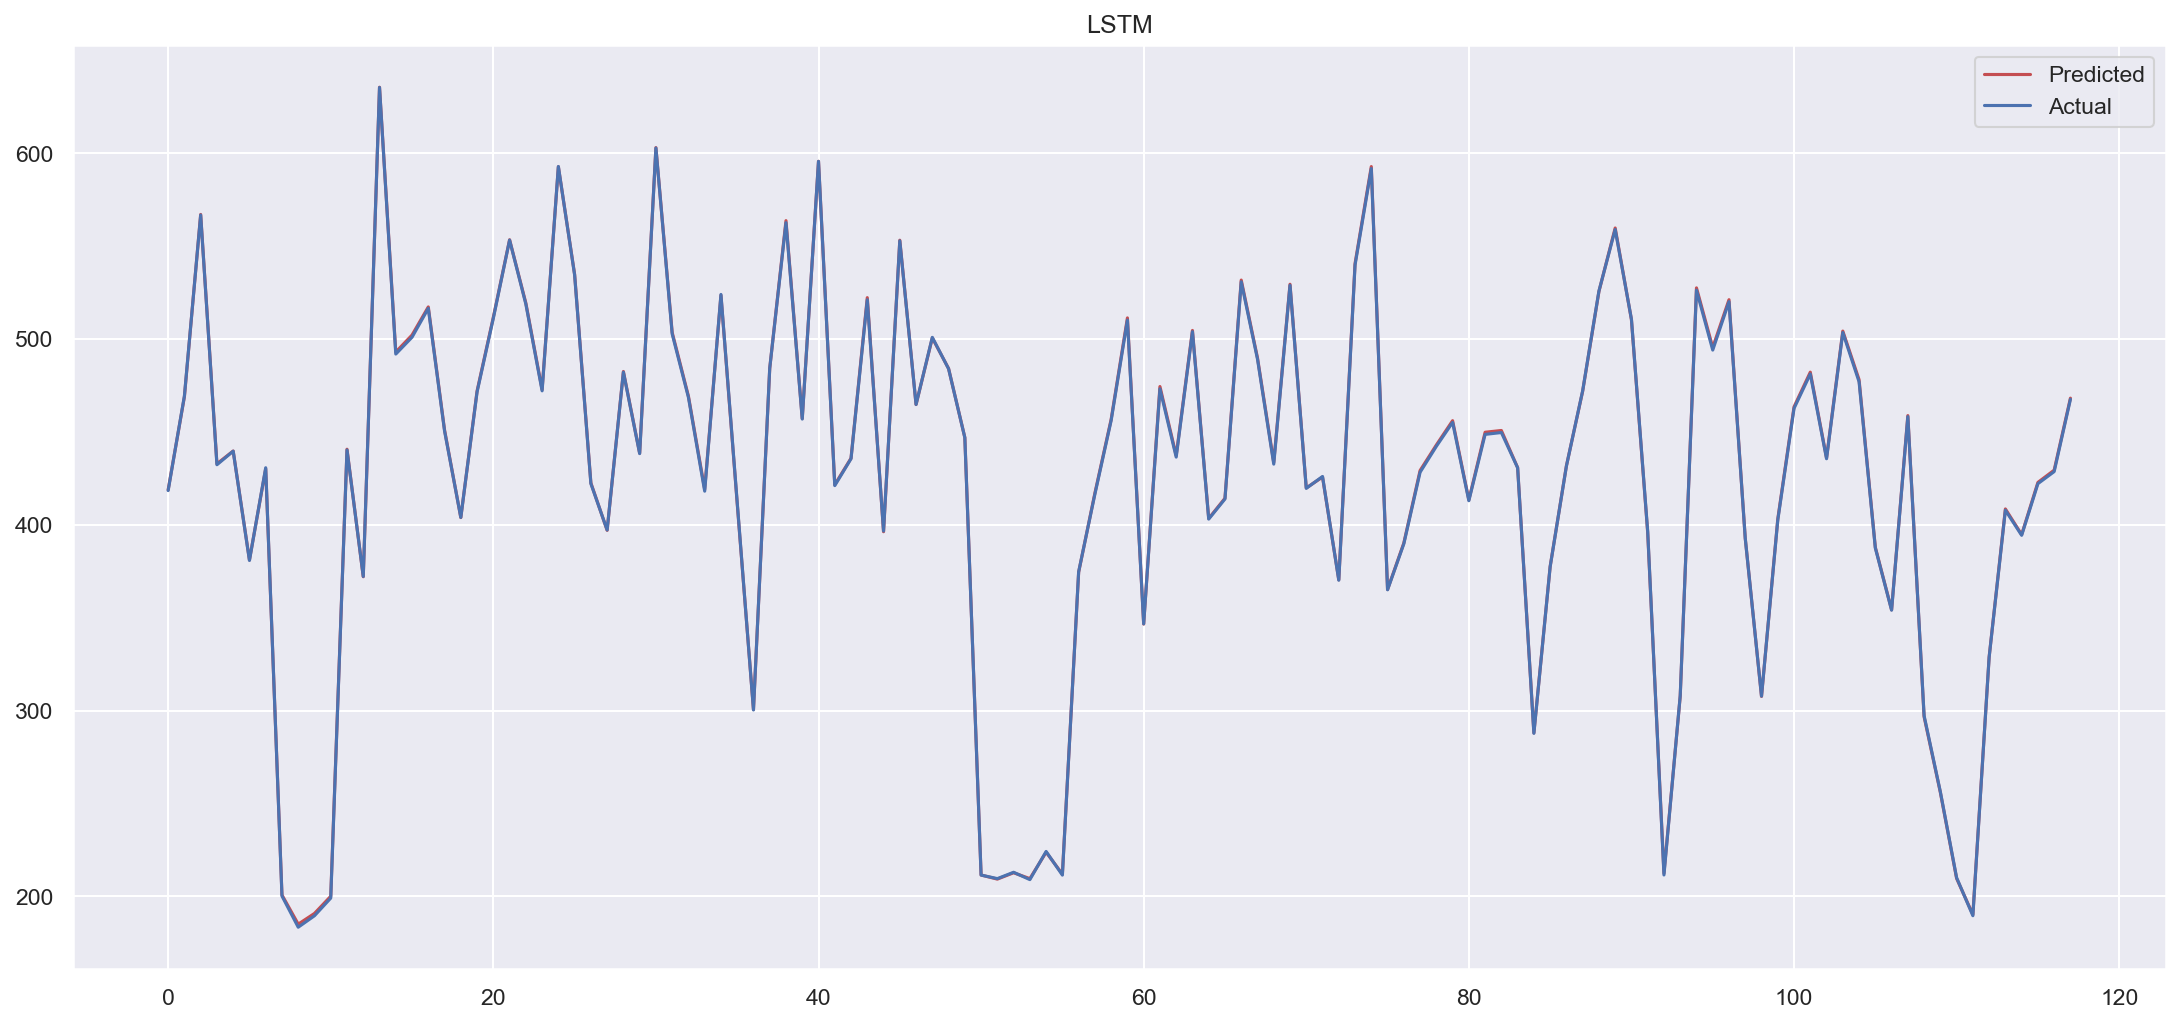

In [62]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
#plt.savefig('2 - LSTM.jpg', dpi=200)
plt.show()

In [ ]:
RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
RNN_preds = RNN_model.predict(x_test_np)

In [ ]:
rnn_preds = scaler_y.inverse_transform(RNN_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['RNN'] = evaluate(y_test_actual, rnn_preds)
evaluate(y_test_actual, rnn_preds)

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.savefig('1 - RNN.jpg', dpi=200)
plt.show()

In [ ]:
GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)
GRU_preds = GRU_model.predict(x_test_np)

In [ ]:
gru_preds = scaler_y.inverse_transform(GRU_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['GRU'] = evaluate(y_test_actual, gru_preds)
evaluate(y_test_actual, gru_preds)

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.savefig('3 - GRU.jpg', dpi=200)
plt.show()

In [ ]:


chosen = dfs.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

# Fit scaler on training data only to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply scaling to each feature separately
scaled_data = chosen.copy()
for column in chosen.columns:
    scaled_data[column] = scaler.fit_transform(chosen[column].values.reshape(-1, 1))

print(scaled_data.shape)
scaled_data.head()

train = scaled_data[:1260]
val = scaled_data[1260:1460]
test = scaled_data[1460:]

x_train = train.drop(["Power"], axis=1)
y_train = train["Power"]
x_val = val.drop(["Power"], axis=1)
y_val = val["Power"]
x_test = test.drop(["Power"], axis=1)
y_test = test["Power"]

In [ ]:

def train_test_split(data, test_index):
    train_val_data = data[:test_index]
    test_data = data[test_index:]

    train_index = int(0.8 * len(train_val_data))
    val_data = train_val_data[train_index:]
    train_data = train_val_data[:train_index]

    x_train = train_data.iloc[:, 1:].values
    y_train = train_data[['Power']].values
    x_val = val_data.iloc[:, 1:].values
    y_val = val_data[['Power']].values
    x_test = test_data.iloc[:, 1:].values
    y_test = test_data[['Power']].values

    return x_train, x_val, x_test, y_train, y_val, y_test



In [ ]:
from tensorflow.keras.models import Sequential
TIME_STEPS, N_FEATURES = 7, 7
rnn, lstm, gru = list(), list(), list()

for i in range(0, len(x_test), 30):
    temp = df.copy()
    x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(temp, i)
    
    x_train_np = create_features(x_train, TIME_STEPS, N_FEATURES)
    x_val_np = create_features(x_val, TIME_STEPS, N_FEATURES)
    x_test_np = create_features(x_test, TIME_STEPS, N_FEATURES)
    # print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
    y_test = y_test[:x_test_np.shape[0]]
    y_train = y_train[:x_train_np.shape[0]]
    y_val = y_val[:x_val_np.shape[0]]
    # print(y_train.shape, y_val.shape, y_test.shape)
    
    if y_test.shape[0] != 0:
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        x_train_scaled = scaler_x.fit_transform(x_train_np)
        x_val_scaled = scaler_x.transform(x_val_np)
        x_test_scaled = scaler_x.transform(x_test_np)
        
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
        
        RNN_model = fit_model(SimpleRNN, 64, x_train_scaled, x_val_scaled)
        LSTM_model = fit_model(LSTM, 64, x_train_scaled, x_val_scaled)
        GRU_model = fit_model(GRU, 64, x_train_scaled, x_val_scaled)

        RNN_preds = RNN_model.predict(x_test_scaled)
        yhat_actual = scaler_y.inverse_transform(RNN_preds)
        rnn.extend(yhat_actual.flatten()[:30])
        
        LSTM_preds = LSTM_model.predict(x_test_scaled)
        yhat_actual = scaler_y.inverse_transform(LSTM_preds)
        lstm.extend(yhat_actual.flatten()[:30])
        
        GRU_preds = GRU_model.predict(x_test_scaled)
        yhat_actual = scaler_y.inverse_transform(GRU_preds)
        gru.extend(yhat_actual.flatten()[:30])


In [ ]:
y_test_actual[7:]

In [ ]:
resultsDict['RNN Rolling'] = evaluate(y_test_actual[7:], rnn)
evaluate(y_test_actual[7:], rnn)